In [37]:
from keras import __version__
import numpy as np
from keras.models import model_from_json, Model, Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from keras import optimizers
from sklearn.model_selection import train_test_split
import keras
from tempfile import TemporaryFile
import random
import csv
from sklearn.neighbors import KDTree
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [66]:
def load_model(weights_path, json_path):
    json_file = open('model_files/' + json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights('model_files/' + weights_path)
    print("Loaded model from disk")
    return loaded_model

def get_clothing_vector_model(weights_path, json_path):
    loaded_model = load_model(weights_path, json_path)
    loaded_model.layers.pop() # Get rid of the classification layer
    last = loaded_model.layers[-1].output
    model = Model(loaded_model.input, last)
    return model

def image_preprocess(img_path):
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)

    # our input image is now represented as a NumPy array of shape
    # (inputShape[0], inputShape[1], 3) however we need to expand the
    # dimension by making the shape (1, inputShape[0], inputShape[1], 3)
    # so we can pass it through thenetwork
    image = np.expand_dims(image, axis=0)

    # pre-process the image using the appropriate function based on the
    # model that has been loaded (i.e., mean subtraction, scaling, etc.)
    image = preprocess_input(image)
    return image

def get_classier_prediction(clothing_classifier, img_path):
    clothes_labels = ['dresses', 'handbags', 'hats', 'jackets', 'jeans', 
                      'jewelry', 'shorts', 'skirts', 'sunglasses', 'sweaters', 
                      'sweatshirts', 'womens-outerwear', 'womens-pants', 'womens-shoes', 'womens-tops']
    img = image_preprocess(img_path)
    preds = clothing_classifier.predict(img)[0]
    preds_labels = list(zip(clothes_labels, preds))
    preds_labels.sort(key=lambda p: p[1], reverse=True)
    return preds_labels

In [58]:
clothing_classifier_weights_path = 'inceptionv3_clothing_expanded_classifier.h5'
clothing_classifier_json_path = 'incep_filter_clothing_expanded_classifier.json'
clothing_classifier = load_model(clothing_classifier_weights_path, clothing_classifier_json_path)
clothing_classifier.summary()

Loaded model from disk
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_234 (Conv2D)              (None, None, None, 32 864         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_233 (BatchNo (None, None, None, 32 96          conv2d_234[0][0]                 
____________________________________________________________________________________________________
activation_233 (Activation)      (None, None, None, 32 0           batch_normalization_233[0][0]    
____________________________________________________________________

In [59]:
jeans_img_path = 'data-all/validation/jeans/482888849.jpg'
dress_img_path = 'data-all/validation/dresses/535993294.jpg'
jackets_img_path = 'data-all/validation/jackets/614521319.jpg'
jackets_img_path2 = 'data-all/validation/jackets/614763686.jpg'
sunglasses_img_path = 'data-all/validation/sunglasses/655241570.jpg'
dog_img_path = 'data-pets/train/dogs/dog.0.jpg'
get_classier_prediction(clothing_classifier, jeans_img_path)

[('jeans', 0.9994086),
 ('womens-pants', 0.00057119632),
 ('skirts', 9.8395294e-06),
 ('shorts', 5.155051e-06),
 ('womens-shoes', 1.597728e-06),
 ('dresses', 1.3391136e-06),
 ('sunglasses', 1.1239276e-06),
 ('handbags', 4.7018787e-07),
 ('womens-tops', 2.4409781e-07),
 ('jackets', 1.8252813e-07),
 ('sweaters', 1.2994238e-07),
 ('womens-outerwear', 1.1318308e-07),
 ('sweatshirts', 6.9145216e-08),
 ('jewelry', 2.7152748e-08),
 ('hats', 1.3843214e-08)]

In [60]:
classifier_vector_model = get_clothing_vector_model(clothing_classifier_weights_path, clothing_classifier_json_path)
img_jacket = image_preprocess(jackets_img_path)
img_jacket2 = image_preprocess(jackets_img_path2)
img_jeans = image_preprocess(jeans_img_path)
img_dress = image_preprocess(dress_img_path)
img_dog = image_preprocess(dog_img_path)

jacket_feat = classifier_vector_model.predict(img_jacket)
jacket_feat2 = classifier_vector_model.predict(img_jacket2)
jeans_feat = classifier_vector_model.predict(img_jeans)
dress_feat = classifier_vector_model.predict(img_dress)
dog_feat = classifier_vector_model.predict(img_dog)

jacket_feat

Loaded model from disk


array([[ 0.4811013 ,  1.57449007,  0.03476679, ...,  1.22023487,
         0.35871762,  0.71462518]], dtype=float32)

In [61]:
# compare cosine similarities
print('2 jackets: ', cosine_similarity(jacket_feat, jacket_feat2))
print('jeans and dress: ', cosine_similarity(jeans_feat, dress_feat))
print('jeans and dog: ', cosine_similarity(jeans_feat, dog_feat))

2 jackets:  [[ 0.97938693]]
jeans and dress:  [[ 0.97675443]]
jeans and dog:  [[ 0.98362172]]


In [ ]:
jacket_feat.shape # (1, 1024)

## Skipgrams Model

In [8]:
def save_product_features(model, product_file, img_dir, output_file):
    products = []
    print('Reading file ', product_file)
    with open(product_file, 'r') as f:
        for i, line in enumerate(f.readlines()[:]):
            if i % 50 == 0:
                print('Processing product ', i)
            try:
                l = line.split('\t')
                product_id = l[0]
                product_img_path = img_dir + product_id + '.jpg' 
                product_img = image_preprocess(product_img_path)
                product_feat = model.predict(product_img)
    
                products.append([product_id] + product_feat[0].tolist())
            except Exception as e:
                print(e)
                
    print('Saving products to ', output_file)
    with open(output_file, 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        for p in products:
            writer.writerow(p)
            f.flush()
    return products

def make_product_permutation_generator(outfit_permutations_file, product_to_features):
    outfit_features = [] # each row = X, y, id
    print('Reading file ', outfit_permutations_file)
    with open(outfit_permutations_file, 'r') as f:
        for line in f:
            try:
                l = line.split()
                product1_id = l[2]
                product2_id = l[5]
                product3_id = l[8]
                product4_id = l[11]
                
                X_products = [(product1_id, l[3]), (product2_id, l[6]), (product3_id, l[9])]
                y_product = (product4_id, l[12])
                
                product1_feat = product_to_features[product1_id]
                product2_feat = product_to_features[product2_id]
                product3_feat = product_to_features[product3_id]
                product4_feat = product_to_features[product4_id]
                
                merged_feat = np.concatenate((product1_feat, product2_feat, product3_feat), axis=1)
                outfit_features.append([merged_feat, product4_feat, 
                                        X_products, y_product])
            except Exception as e:
                print(e)
    random.shuffle(outfit_features)
    
    X = []
    y = []
    X_products = []
    y_products = []
    for outfit in outfit_features:
        X.append(outfit[0])
        y.append(outfit[1])
        X_products.append(outfit[2])
        y_products.append(outfit[3])
    return np.array(X), np.array(y), X_products, y_products

def get_product_to_features(product_feats_file):
    product_to_feats = {}
    with open(product_feats_file, 'r') as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter='\t')
        for row in tsvreader:
            product_id = row[0]
            feats = np.array([[float(n) for n in row[1:]]])
            product_to_feats[product_id] = feats
    return product_to_feats

In [ ]:
# Run one time to save product weights
# save_product_features(classifier_vector_model, 'data-outfits/outfit_products.tsv', 
#                       'data-outfits/images/', 'data-outfits/outfit_product_features.tsv')

In [5]:
product_feats_file = 'data-outfits/outfit_product_features.tsv'
outfit_permutations_file = 'data-outfits/outfit_permutations.tsv'
prods_to_feats = get_product_to_features(product_feats_file)
prods_to_feats['615752261']

array([[ 0.42040107,  1.48408139,  0.11978239, ...,  2.25705886,
         0.37974471,  0.94305986]])

In [76]:
outfit_permutations_file_temp = 'data-outfits/outfit_permutations_temp.tsv'
(X, y, X_products, y_products) = make_product_permutation_generator(outfit_permutations_file_temp, prods_to_feats)

Reading file  data-outfits/outfit_permutations_temp.tsv


In [10]:
np.array(X).shape # (400, 1, 2048)

(20000, 1, 3072)

In [11]:
def make_skipgrams_clothing_model():
    seq = Sequential()
    seq.add(Dense(1024, input_shape=(1,3072), activation='relu', name='fc1'))
    seq.add(Dropout(0.3))
    seq.add(Dense(256, activation='relu', name='fc2'))
    seq.add(Dropout(0.2))
    #seq.add(Flatten())
    seq.add(Dense(1024, activation='softmax', name='fc_final'))
    seq.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=0.00001), metrics=["accuracy"])
    return seq

In [65]:
def fit_save_skipgram_clothing_model(weights_file, json_file):
    model = make_skipgrams_clothing_model()
    model.fit(X, y, validation_split=0.3, epochs=10, batch_size=10)
    model.save('model_files/' + weights_file)
    model_json = model.to_json()
    with open('model_files/' + json_file, 'w') as json_file:
        json_file.write(model_json)
    return model

skipgram_model_weights_file = 'outfit_skipgram_model_weights.h5'
skipgram_model_json_file = 'outfit_skipgram_model.json'
fit_save_skipgram_clothing_model(skipgram_model_weights_file, skipgram_model_json_file)

Train on 14000 samples, validate on 6000 samples
Epoch 1/10
14000/14000 [==============================] - 19s - loss: 9980.5961 - acc: 0.0827 - val_loss: 9559.6301 - val_acc: 0.7643
Epoch 2/10
14000/14000 [==============================] - 18s - loss: 9585.4040 - acc: 0.2629 - val_loss: 9534.2671 - val_acc: 0.9052
Epoch 3/10
14000/14000 [==============================] - 18s - loss: 9557.1713 - acc: 0.3629 - val_loss: 9531.9944 - val_acc: 0.9598
Epoch 4/10
14000/14000 [==============================] - 18s - loss: 9547.2296 - acc: 0.4515 - val_loss: 9529.4046 - val_acc: 0.9857
Epoch 5/10
14000/14000 [==============================] - 18s - loss: 9541.7574 - acc: 0.5179 - val_loss: 9528.6396 - val_acc: 0.9928
Epoch 6/10
14000/14000 [==============================] - 18s - loss: 9538.5370 - acc: 0.5739 - val_loss: 9525.8386 - val_acc: 0.9908
Epoch 7/10
14000/14000 [==============================] - 18s - loss: 9536.5832 - acc: 0.6330 - val_loss: 9524.9701 - val_acc: 0.9942
Epoch 8/10
14

In [67]:
clothing_skipgrams_model = load_model(skipgram_model_weights_file, skipgram_model_json_file)

Loaded model from disk


In [68]:
def display_product_images(product_ids):
    image_count = len(product_ids)
    fig, ax = plt.subplots(1, image_count, figsize=(image_count*5, 4))
    
    for i, product_id in enumerate(product_ids):
        image_file = 'data-outfits/images/' + product_id + '.jpg'
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        ax[i].imshow(image, interpolation='nearest')
        ax[i].axis("off")
    plt.show()
    
def get_prod_feat_list():
    index_to_prod = {}
    prod_features = []
    for i, prod_feat in enumerate(prods_to_feats.items()):
        prod_id, feat = prod_feat
        index_to_prod[i] = prod_id
        prod_features.append(feat[0])
    return index_to_prod, np.array(prod_features)

def get_closest_product_ids(input_features, tree, index_to_prod_mapping):
    results = tree.query(input_features, k=5, return_distance=False)[0]
    return [index_to_prod_mapping[index] for index in results]

index_to_prod, prod_features = get_prod_feat_list()
print('Making KD Tree ...')
productTree = KDTree(prod_features, leaf_size=50)
prod_features[:3]

array([[ 0.        ,  5.85957146,  1.24812102, ...,  6.95872259,
         1.77266467,  3.18993473],
       [ 0.38827777,  3.8499105 ,  0.56135225, ...,  5.08135939,
         1.19380879,  2.65321469],
       [ 0.53009707,  3.31409311,  0.47977686, ...,  5.19207239,
         2.10588574,  2.59770107]])

In [77]:
clothing_predictions = list(zip(X_products, clothing_skipgrams_model.predict(X)))
clothing_predictions[:3]

[([('602996688', 'sunglasses'),
   ('631903404', 'sweaters'),
   ('502987397', 'jeans')],
  array([[ 0.00020397,  0.00175948,  0.00024324, ...,  0.00243835,
           0.00070025,  0.00122327]], dtype=float32)),
 ([('635126273', 'womens-shoes'),
   ('443997344', 'sunglasses'),
   ('643247613', 'womens-tops')],
  array([[ 0.00024917,  0.00180399,  0.00028404, ...,  0.00232293,
           0.00076782,  0.0013349 ]], dtype=float32)),
 ([('625729145', 'jackets'),
   ('654268394', 'womens-shoes'),
   ('655437095', 'womens-tops')],
  array([[ 0.00021678,  0.00173312,  0.00025108, ...,  0.00239711,
           0.00069504,  0.00122266]], dtype=float32))]

[('602996688', 'sunglasses'), ('631903404', 'sweaters'), ('502987397', 'jeans')]
0 Input Products: ['602996688', '631903404', '502987397']


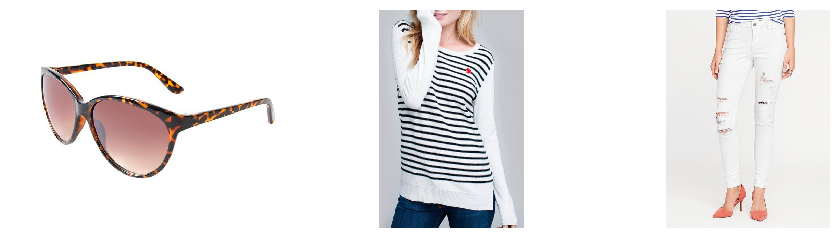

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


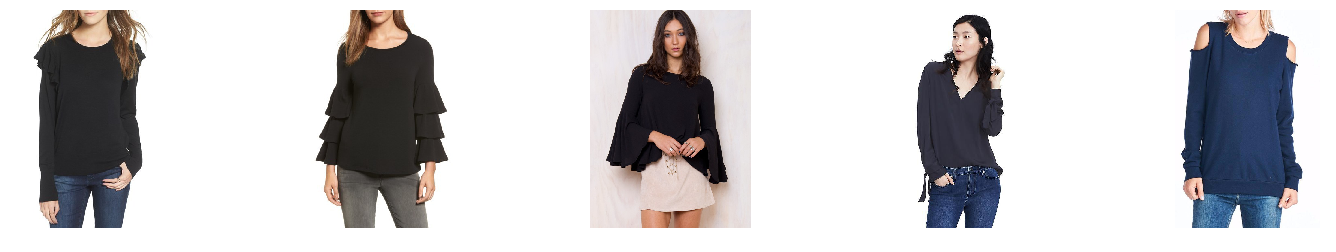

[('635126273', 'womens-shoes'), ('443997344', 'sunglasses'), ('643247613', 'womens-tops')]
1 Input Products: ['635126273', '443997344', '643247613']


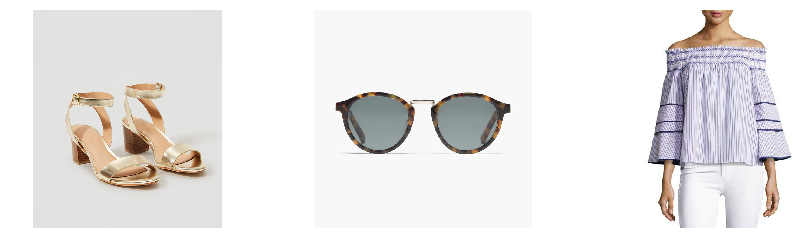

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


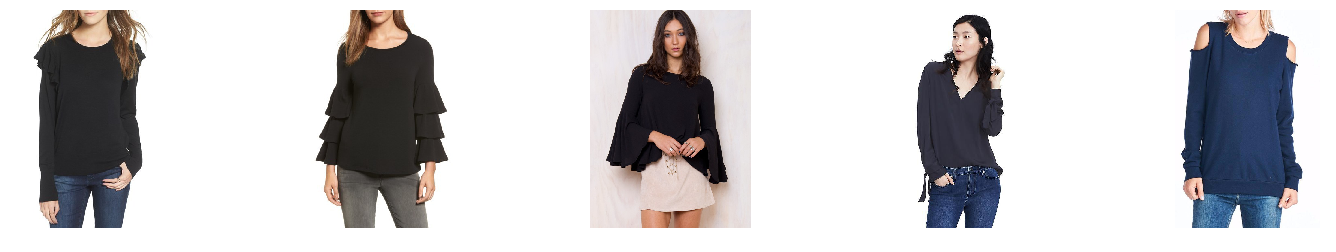

[('625729145', 'jackets'), ('654268394', 'womens-shoes'), ('655437095', 'womens-tops')]
2 Input Products: ['625729145', '654268394', '655437095']


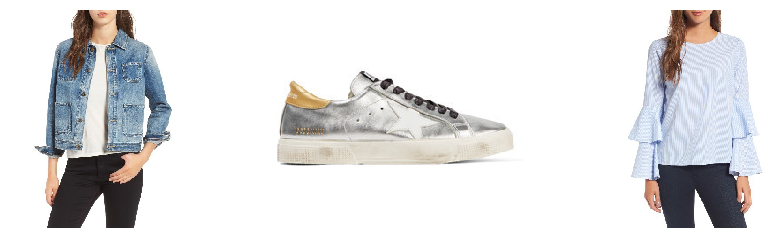

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


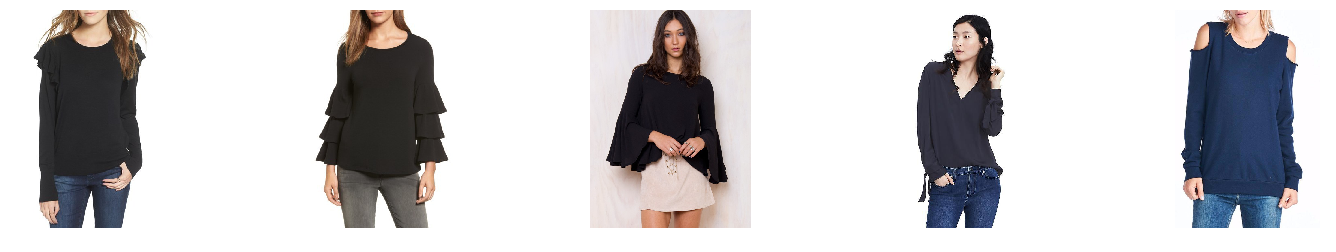

[('625729145', 'jackets'), ('380490815', 'sunglasses'), ('528822553', 'skirts')]
3 Input Products: ['625729145', '380490815', '528822553']


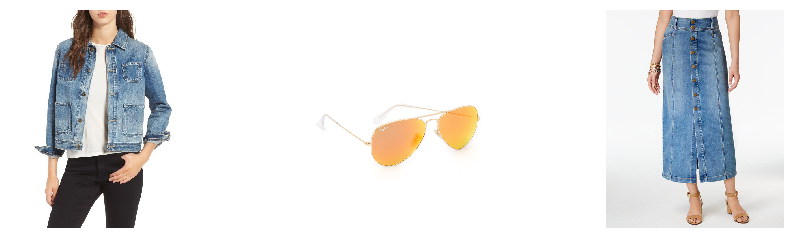

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


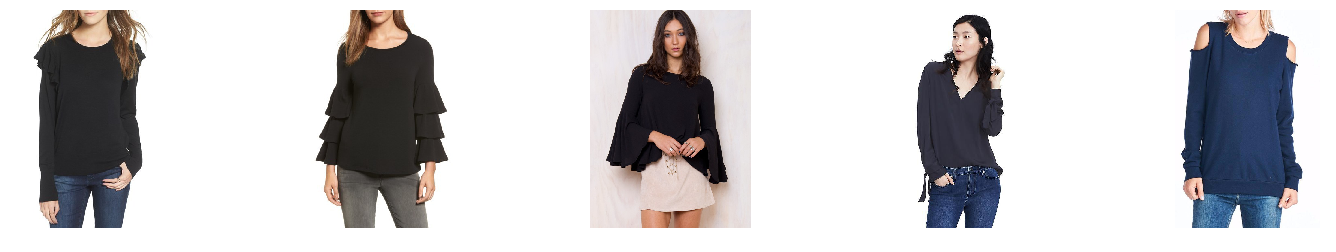

[('659183688', 'womens-shoes'), ('537657613', 'handbags'), ('624143089', 'jewelry')]
4 Input Products: ['659183688', '537657613', '624143089']


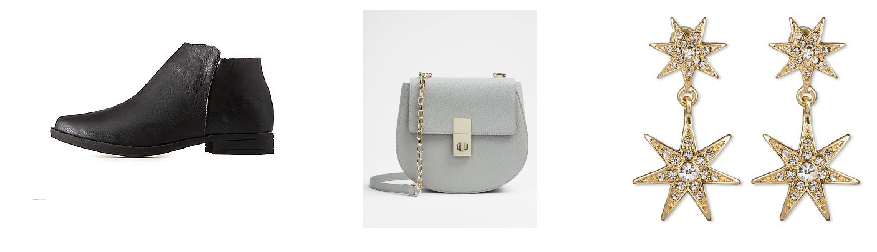

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


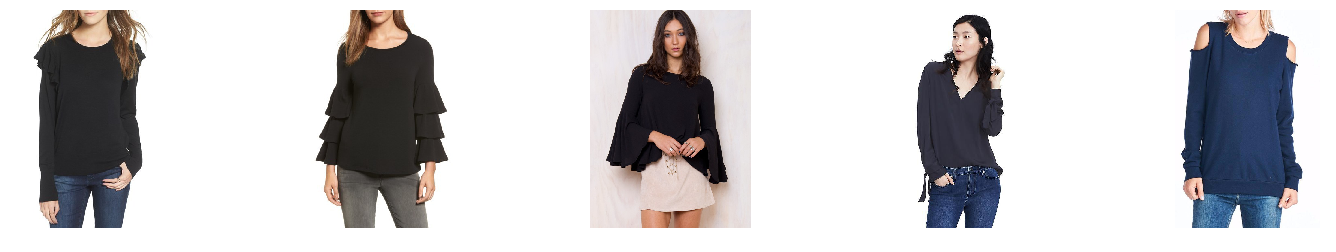

[('533068837', 'womens-pants'), ('619547520', 'handbags'), ('511820802', 'womens-shoes')]
5 Input Products: ['533068837', '619547520', '511820802']


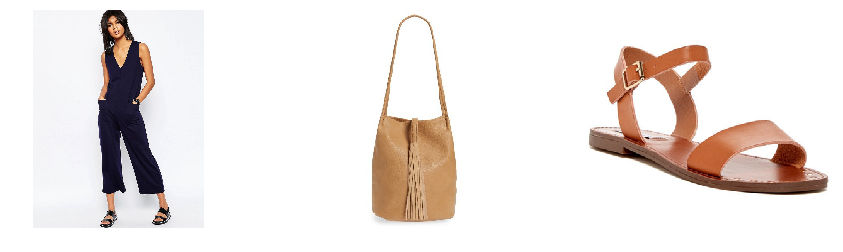

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


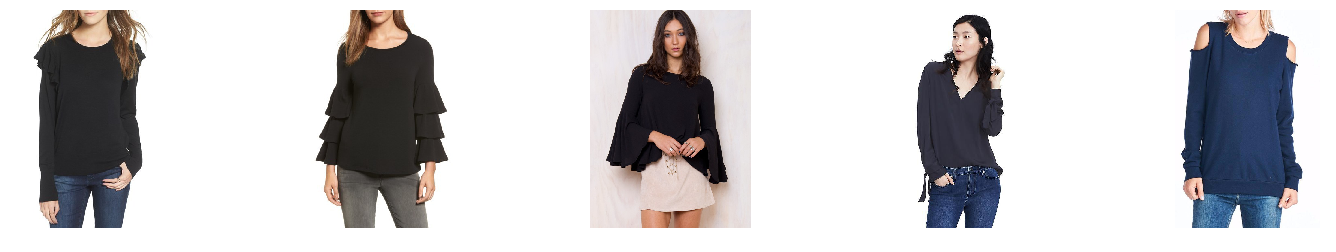

[('645498018', 'handbags'), ('622694318', 'sunglasses'), ('461761278', 'hats')]
6 Input Products: ['645498018', '622694318', '461761278']


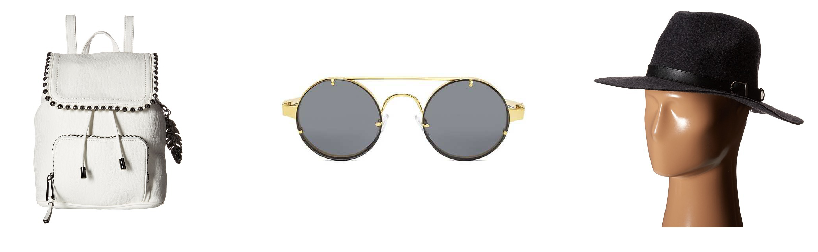

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


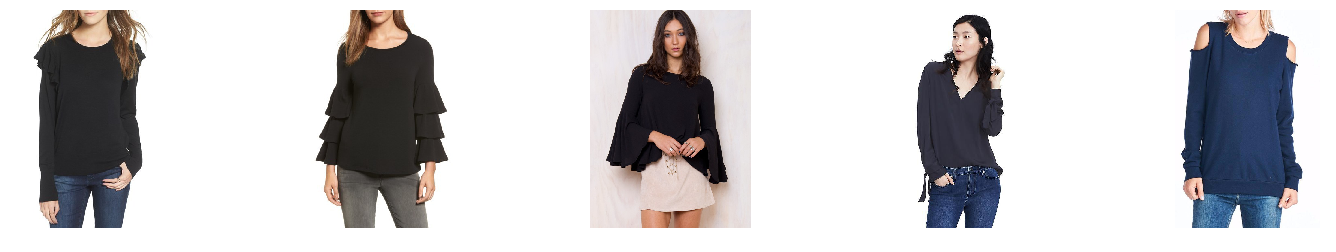

[('625992208', 'handbags'), ('614409038', 'jeans'), ('627026698', 'jackets')]
7 Input Products: ['625992208', '614409038', '627026698']


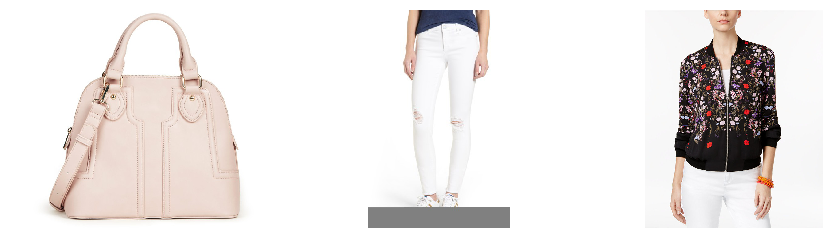

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


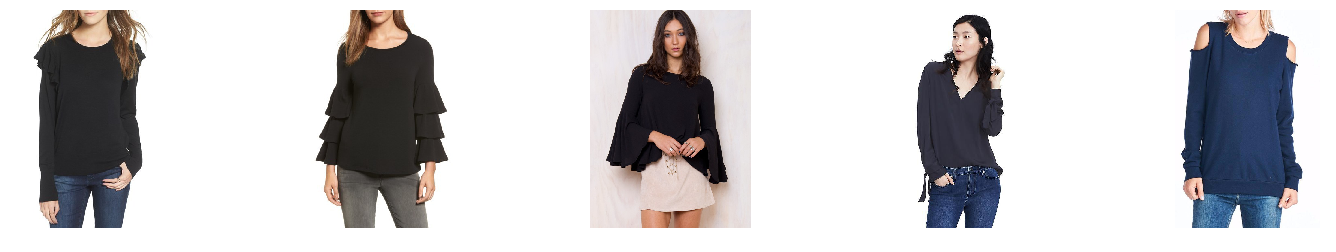

[('538663038', 'handbags'), ('629704804', 'sweaters'), ('608147462', 'jeans')]
8 Input Products: ['538663038', '629704804', '608147462']


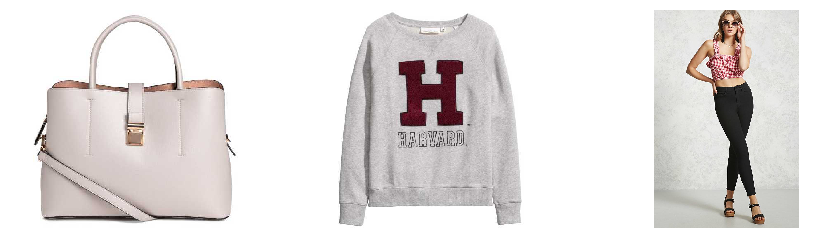

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


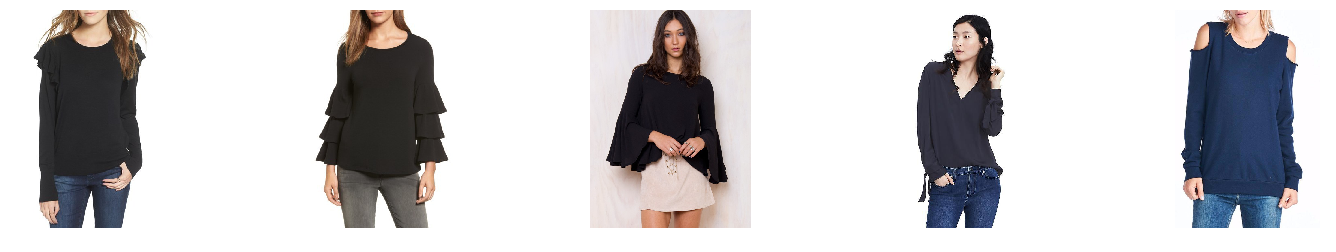

[('628574448', 'womens-tops'), ('530560831', 'sunglasses'), ('519722686', 'womens-shoes')]
9 Input Products: ['628574448', '530560831', '519722686']


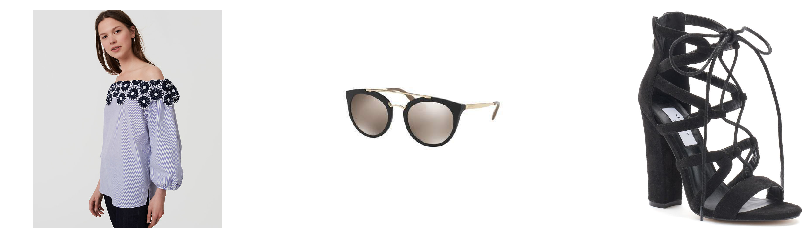

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


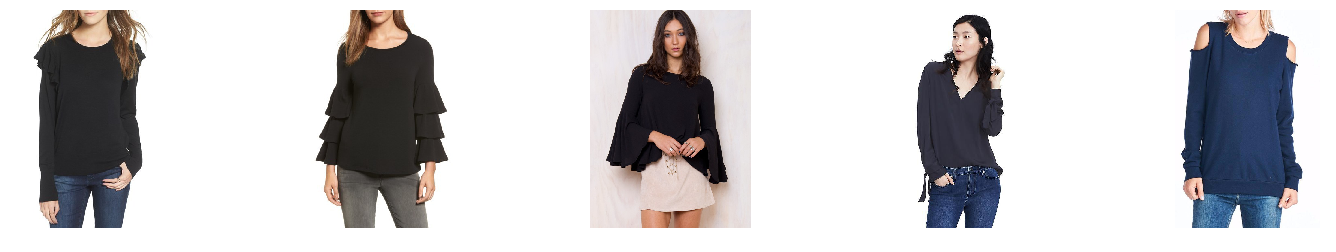

[('631877271', 'womens-tops'), ('506694061', 'hats'), ('449534619', 'jewelry')]
10 Input Products: ['631877271', '506694061', '449534619']


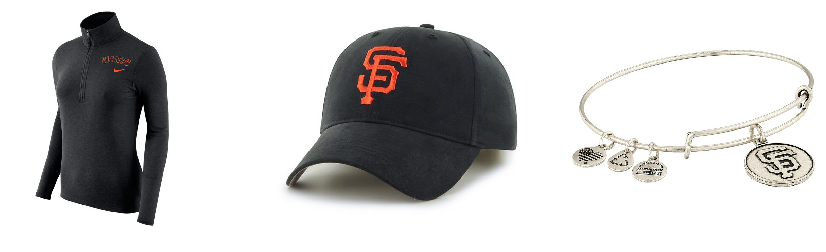

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


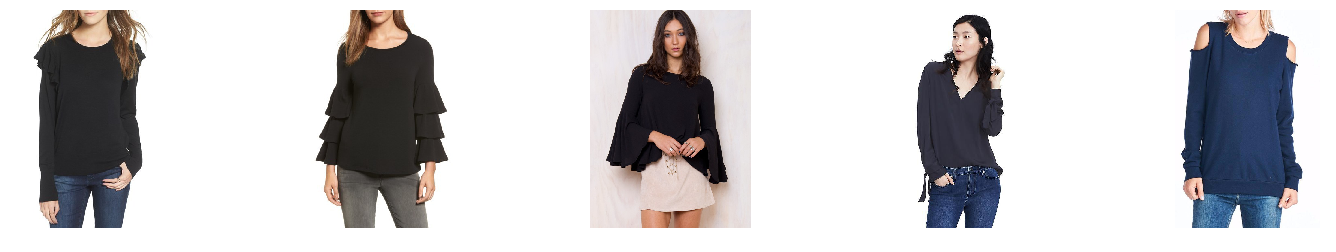

[('526153263', 'jewelry'), ('621773875', 'womens-shoes'), ('602756480', 'womens-outerwear')]
11 Input Products: ['526153263', '621773875', '602756480']


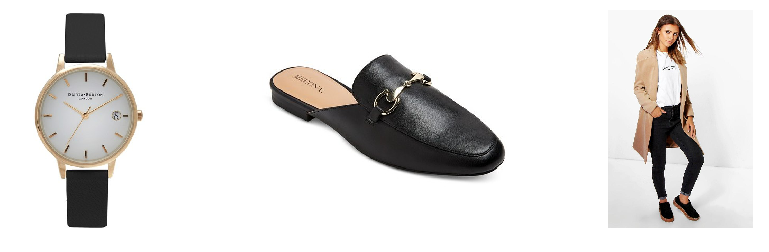

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


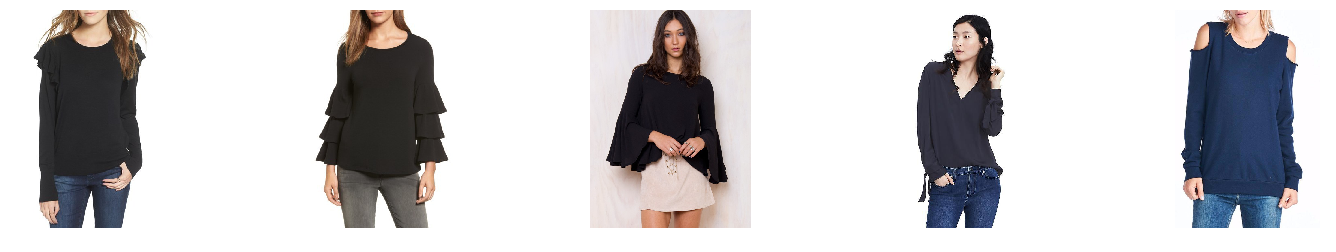

[('615082171', 'handbags'), ('511147107', 'womens-shoes'), ('533167475', 'jeans')]
12 Input Products: ['615082171', '511147107', '533167475']


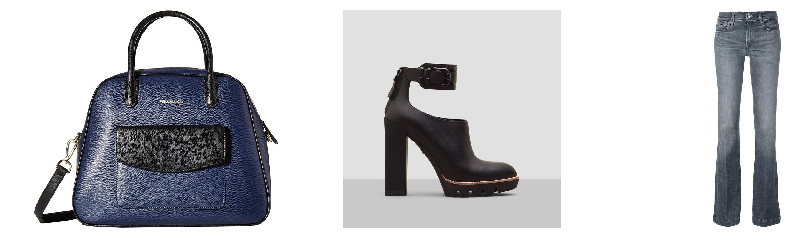

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


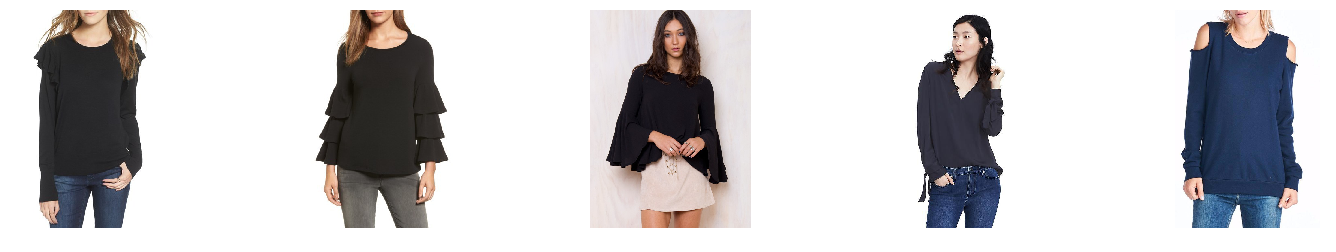

[('525769960', 'shorts'), ('624143089', 'jewelry'), ('602750872', 'hats')]
13 Input Products: ['525769960', '624143089', '602750872']


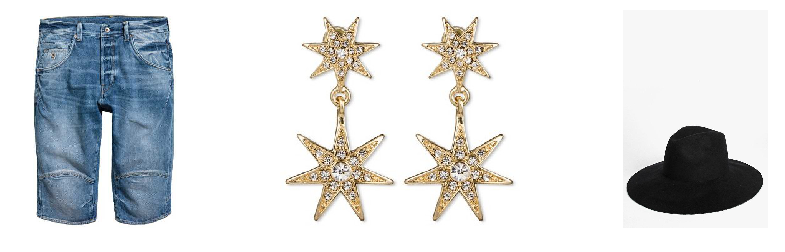

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


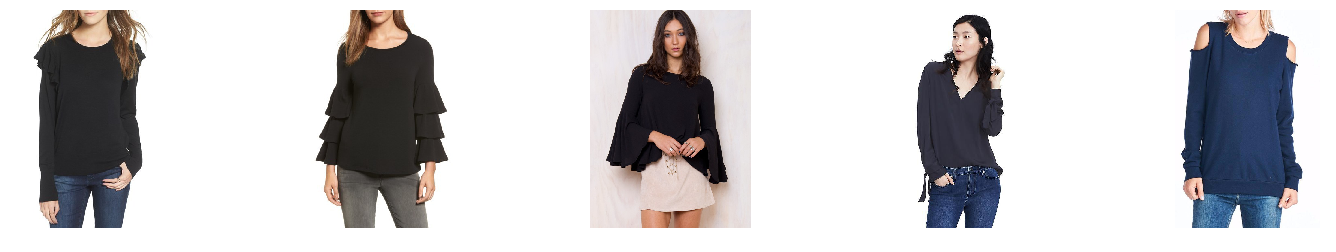

[('619392205', 'womens-shoes'), ('609250818', 'womens-pants'), ('524998066', 'sunglasses')]
14 Input Products: ['619392205', '609250818', '524998066']


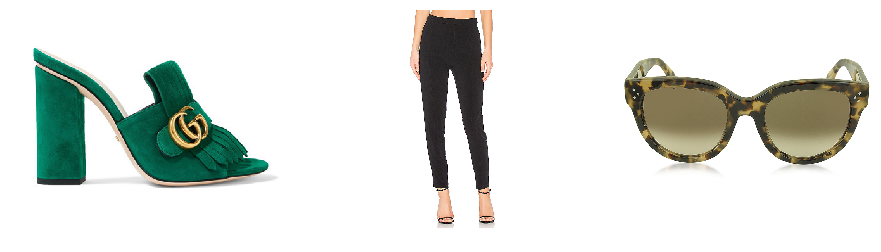

Closest products: ['612712533', '656260753', '485129799', '616386608', '625027516']


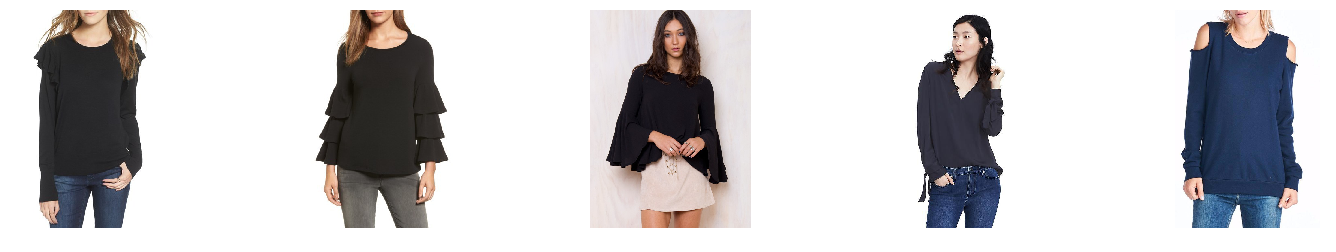

In [78]:
for i, pred in enumerate(clothing_predictions[:15]):
    input_products, prediction_vector = pred 
    input_product_ids = [p[0] for p in input_products] 
    print('{} Input Products: {}'.format(i, input_product_ids))
    display_product_images(input_product_ids)
    closest_product_ids = get_closest_product_ids(prediction_vector, productTree, index_to_prod)
    print('Closest products: {}'.format(closest_product_ids))
    display_product_images(closest_product_ids)

In [ ]:
a = np.array([[1,2, 3]])
b = np.array([[4,5, 6]])
ab = np.concatenate((a, b, a), axis=1)